In [15]:
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime
import ipywidgets as widgets
from IPython.display import HTML, display
from collections import defaultdict

In [16]:
eq_table = pd.read_csv('../Data/04_deadly_eq_mag_cleaned.csv', index_col=False)

In [17]:
eq_table

,origin (utc),present-day country and link to wikipedia article,lat,long,depth (km),magnitude,secondary effects,pde shaking deaths,pde total deaths,utsu total deaths,em-dat total deaths,other source deaths,deats,deaths,original_magnitude,original_magnitude_scale
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,MJMA
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN,140.0,140.0,5.9,Muk
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7,Mw
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,Ms
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN,4.0,4.0,6.4,Muk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,2011-03-24 20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,NaN,NaN,NaN,NaN,NaN,150.0,150.0,150.0,6.8,Mw
1336,2011-04-07 14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,Mw
1337,2011-09-18 12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,NaN,111.0,111.0,111.0,6.9,Mw
1338,2011-09-23 10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,NaN,601.0,601.0,601.0,7.1,Mw


In [18]:
eq_table['origin (utc)'] = pd.to_datetime(eq_table['origin (utc)'])

In [19]:
eq_table['year'] = eq_table['origin (utc)'].dt.year

In [20]:
eq_table['present-day country and link to wikipedia article']

0                                          Japan
1                                         Turkey
2                                      Venezuela
3                                          China
4                                       Bulgaria
                          ...                   
1335           Burma (see 2011 Burma earthquake)
1336    Japan (see April 2011 Miyagi earthquake)
1337          India (see 2011 Sikkim earthquake)
1338            Turkey (see 2011 Van earthquake)
1339           Indonesia (see Lombok earthquake)
Name: present-day country and link to wikipedia article, Length: 1340, dtype: object

In [21]:
eq_table['country'] = eq_table['present-day country and link to wikipedia article'].apply(lambda x: x.split(' (', 1)[0])

In [24]:
eq_table.iloc[1033]['country']

'(see 1997 Cariaco earthquake)'

In [27]:
eq_table.at[1033, 'country'] = 'Venezuela'

In [63]:
eq_table.groupby('country')['origin (utc)'].count().to_dict()

{'Afghanistan': 30,
 'Albania': 7,
 'Algeria': 21,
 'Argentina': 11,
 'Armenia': 2,
 'Australia': 3,
 'Azerbaijan': 5,
 'Bangladesh': 7,
 'Belgium': 1,
 'Bolivia': 3,
 'Bosnia and Herzegovina': 3,
 'Brazil': 1,
 'Bulgaria': 5,
 'Burma': 11,
 'Burundi': 1,
 'Canada': 3,
 'Chile': 44,
 'China': 166,
 'Colombia': 24,
 'Costa Rica': 10,
 'Cuba': 2,
 'Cyprus': 3,
 'Czech Republic': 1,
 'Democratic Republic of the Congo': 6,
 'Djibouti': 1,
 'Dominican Republic': 5,
 'Ecuador': 19,
 'Egypt': 4,
 'El Salvador': 7,
 'England': 1,
 'Eritrea': 1,
 'Ethiopia': 2,
 'Fiji': 1,
 'France': 4,
 'Georgia': 9,
 'Ghana': 1,
 'Greece': 44,
 'Guadeloupe': 1,
 'Guatemala': 15,
 'Guinea': 1,
 'Haiti': 3,
 'Honduras': 1,
 'Hungary': 1,
 'Iceland': 2,
 'India': 25,
 'Indonesia': 97,
 'Iran': 91,
 'Iran, 2005 Qeshm earthquake': 1,
 'Iraq': 1,
 'Italy': 37,
 'Jamaica': 2,
 'Japan': 82,
 'Kazakhstan': 4,
 'Kingdom of Yugoslavia': 1,
 'Kyrgyzstan': 6,
 'Macedonia': 1,
 'Malawi': 2,
 'Malaysia': 1,
 'Mandatory Pale

In [29]:
corr = eq_table.corr()

In [30]:
mask = np.triu(np.ones_like(corr, dtype=bool))

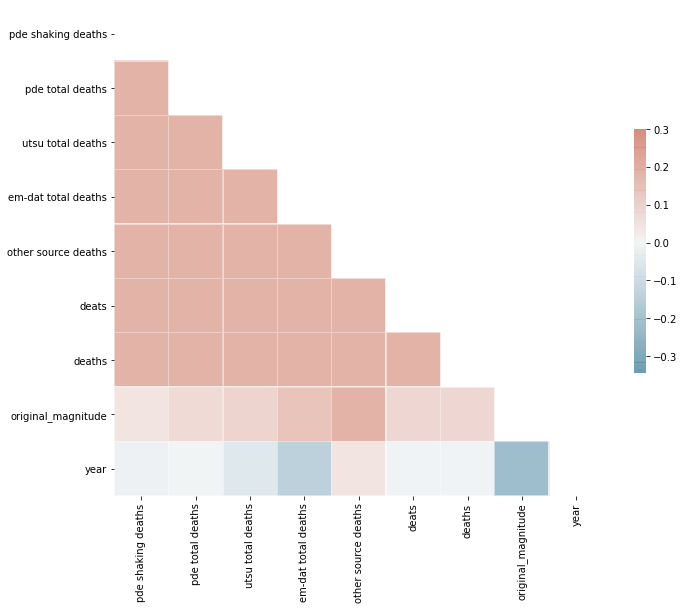

In [32]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},  alpha=.5);

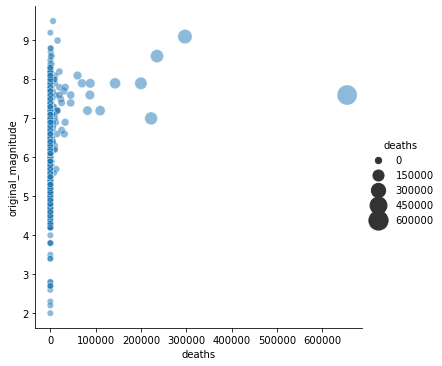

In [33]:
sns.relplot(x='deaths', y='original_magnitude', data=eq_table, size='deaths', sizes=(40, 400), alpha=.5, palette="muted",);

# Doesn't appear to be a correlation between magnitude and deaths on overall

- Download Population data as CSV data from http://data.un.org/Data.aspx?q=population&d=PopDiv&f=variableID%3a12
- Rename file to un_pop_data.csv

In [35]:
un_pop = pd.read_csv(r"../data/un_pop_data.csv")

In [36]:
un_pop.columns

Index(['Country or Area', 'Year(s)', 'Variant', 'Value'], dtype='object')

In [37]:
un_pop_medium = un_pop[un_pop['Variant'] =='Medium']

In [38]:
un_pop_medium = un_pop_medium.rename(columns = {"Value": "population", "Year(s)": "year"})

In [39]:
un_pop_medium['country_join'] = un_pop_medium['Country or Area'].str.lower()

In [40]:
eq_table['country_join'] = eq_table['country'].str.lower()

In [83]:
eq_table['country_join']

0           japan
1          turkey
2       venezuela
3           china
4        bulgaria
          ...    
1335        burma
1336        japan
1337        india
1338       turkey
1339    indonesia
Name: country_join, Length: 1340, dtype: object

In [41]:
eq_table_pop = eq_table.merge(un_pop_medium, on=['country_join', 'year'])

In [43]:
eq_table_pop.shape

(278, 22)

In [44]:
eq_table_pop[['deaths', 'population']].corr()

,deaths,population
deaths,1.000000,0.064417
population,0.064417,1.000000


# in the matchable subset, there is a negative correlation with population

- Download GDP data as CSV data from http://data.un.org/Data.aspx?q=gdp&d=SNAAMA&f=grID%3a101%3bcurrID%3aUSD%3bpcFlag%3a1
- Rename file to un_per_capita_gdp.csv

In [45]:
un_gdp = pd.read_csv(r"../data/un_per_capita_gdp.csv", skipfooter=2)

<ipython-input-45-bfa48b5609f6>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  un_gdp = pd.read_csv(r"../data/un_per_capita_gdp.csv", skipfooter=2)


In [46]:
un_gdp = un_gdp.rename(columns = {"Value": "gdp", "Country or Area": "country", "Year": "year"})

In [47]:
un_gdp = un_gdp[un_gdp['Item']=='Gross Domestic Product (GDP)']

In [48]:
un_gdp['country_join'] = un_gdp['country'].str.lower()

In [49]:
un_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9869 entries, 0 to 9868
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       9869 non-null   object 
 1   year          9869 non-null   int64  
 2   Item          9869 non-null   object 
 3   gdp           9869 non-null   float64
 4   country_join  9869 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 462.6+ KB


In [84]:
eq_table_gdp = eq_table.merge(un_gdp, on=['country_join', 'year'] )

In [85]:
eq_table_gdp.columns

Index(['origin (utc)', 'present-day country and link to wikipedia article',
       'lat', 'long', 'depth (km)', 'magnitude', 'secondary effects',
       'pde shaking deaths', 'pde total deaths', 'utsu total deaths',
       'em-dat total deaths', 'other source deaths', 'deats', 'deaths',
       'original_magnitude', 'original_magnitude_scale', 'year', 'country_x',
       'country_join', 'country_y', 'Item', 'gdp'],
      dtype='object')

In [72]:
missing_countries = eq_table[~eq_table['country'].isin(eq_table_pop_gdp['country_x'].to_list())]

In [81]:
missing_countries[missing_countries['country'].str.contains('Japan')]

,origin (utc),present-day country and link to wikipedia article,lat,long,depth (km),magnitude,secondary effects,pde shaking deaths,pde total deaths,utsu total deaths,em-dat total deaths,other source deaths,deats,deaths,original_magnitude,original_magnitude_scale,year,country,country_join
0,1900-05-11 17:23:00,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,MJMA,1900,Japan,japan
5,1901-08-09 09:23:00,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,Mw,1901,Japan,japan
7,1902-01-30 14:01:00,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,6.9,Ms,1902,Japan,japan
26,1905-06-02 05:39:00,Japan,34.100,132.500,55,7.0 mb,NaN,NaN,NaN,11.0,NaN,NaN,11.0,11.0,7.0,mb,1905,Japan,japan
50,1909-08-14 06:31:00,Japan,35.400,136.300,5,6.7 Ms,NaN,NaN,NaN,41.0,NaN,NaN,41.0,41.0,6.7,Ms,1909,Japan,japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,2007-07-16 01:13:00,Japan (see 2007 Chūetsu offshore earthquake),37.520,138.460,12,6.6 Mw,"T,L",9.0,9.0,NaN,9.0,NaN,9.0,9.0,6.6,Mw,2007,Japan,japan
1312,2008-06-13 23:43:00,Japan (see 2008 Iwate–Miyagi Nairiku earthquake),39.030,140.881,7,6.9 Mw,L,13.0,13.0,NaN,13.0,NaN,13.0,13.0,6.9,Mw,2008,Japan,japan
1323,2009-08-10 20:07:00,Japan (see 2009 Shizuoka earthquake),NaN,NaN,NaN,6.4 Mw,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,6.4,Mw,2009,Japan,japan
1334,2011-03-11 14:46:00,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,NaN,15894.0,15894.0,15894.0,9.0,Mw,2011,Japan,japan


In [79]:
un_gdp[un_gdp['country'].str.contains('Japan')]

,country,year,Item,gdp,country_join
4585,Japan,2018,Gross Domestic Product (GDP),39082.055125,japan
4586,Japan,2017,Gross Domestic Product (GDP),38116.444637,japan
4587,Japan,2016,Gross Domestic Product (GDP),38560.904712,japan
4588,Japan,2015,Gross Domestic Product (GDP),34296.761817,japan
4589,Japan,2014,Gross Domestic Product (GDP),37843.996580,japan
4590,Japan,2013,Gross Domestic Product (GDP),40180.410720,japan
4591,Japan,2012,Gross Domestic Product (GDP),48302.761503,japan
4592,Japan,2011,Gross Domestic Product (GDP),47918.359458,japan
4593,Japan,2010,Gross Domestic Product (GDP),44344.124576,japan
4594,Japan,2009,Gross Domestic Product (GDP),40693.676587,japan


In [86]:
eq_table_gdp[['deaths', 'gdp']].corr()

,deaths,gdp
deaths,1.000000,-0.031869
gdp,-0.031869,1.000000


<AxesSubplot:xlabel='deaths', ylabel='gdp'>

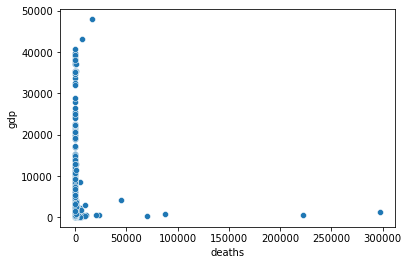

In [87]:
sns.scatterplot(x='deaths', y='gdp', data=eq_table_gdp[['deaths', 'gdp']])

In [91]:
eq_table_gdp['log_deaths'] = np.log(eq_table_pop_gdp['deaths'])

In [92]:
eq_table_gdp

,origin (utc),present-day country and link to wikipedia article,lat,long,depth (km),magnitude,secondary effects,pde shaking deaths,pde total deaths,utsu total deaths,...,deaths,original_magnitude,original_magnitude_scale,year,country_x,country_join,country_y,Item,gdp,log_deaths
0,1970-01-20 17:33:00,Japan,42.523,143.024,34.9,6.4 Ms,NaN,1.0,1.0,NaN,...,1.0,6.4,Ms,1970,Japan,japan,Japan,Gross Domestic Product (GDP),2026.214670,0.000000
1,1970-02-05 22:05:00,Philippines,12.600,122.058,7.7,6.6 Ms,NaN,3.0,3.0,3.0,...,3.0,6.6,Ms,1970,Philippines,philippines,Philippines,Gross Domestic Product (GDP),207.049795,0.000000
2,1970-04-07 05:34:00,Philippines,15.772,121.659,28.3,7.2 Mw,NaN,14.0,14.0,15.0,...,15.0,7.2,Mw,1970,Philippines,philippines,Philippines,Gross Domestic Product (GDP),207.049795,4.442651
3,1970-03-28 21:02:00,Turkey (see 1970 Gediz earthquake),39.172,29.550,24.2,7.4 Muk,NaN,1086.0,1086.0,1086.0,...,1086.0,7.4,Muk,1970,Turkey,turkey,Turkey,Gross Domestic Product (GDP),717.749250,2.397895
4,1970-05-31 20:23:00,Peru (see 1970 Ancash earthquake),-9.248,-78.840,73,7.9 Muk,L,0.0,70000.0,66794.0,...,70000.0,7.9,Muk,1970,Peru,peru,Peru,Gross Domestic Product (GDP),433.072260,3.258097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,2011-03-11 14:46:00,Japan (see 2011 Tōhoku earthquake),38.322,142.369,24.4,9.0 Mw,T,NaN,NaN,NaN,...,15894.0,9.0,Mw,2011,Japan,japan,Japan,Gross Domestic Product (GDP),47918.359458,NaN
614,2011-04-07 14:32:00,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,NaN,NaN,NaN,NaN,...,NaN,7.1,Mw,2011,Japan,japan,Japan,Gross Domestic Product (GDP),47918.359458,NaN
615,2011-09-18 12:40:00,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,L,NaN,NaN,NaN,...,111.0,6.9,Mw,2011,India,india,India,Gross Domestic Product (GDP),1497.189524,NaN
616,2011-09-23 10:41:00,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,NaN,NaN,NaN,NaN,...,601.0,7.1,Mw,2011,Turkey,turkey,Turkey,Gross Domestic Product (GDP),11335.912705,NaN


<AxesSubplot:xlabel='log_deaths', ylabel='gdp'>

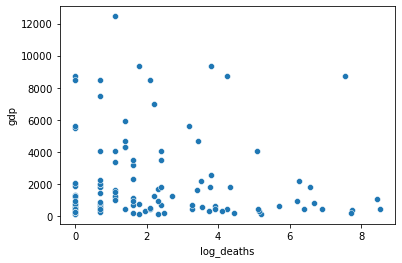

In [93]:
sns.scatterplot(x='log_deaths', y='gdp', data=eq_table_gdp[['log_deaths', 'gdp']])

In [94]:
eq_table_gdp[['log_deaths', 'gdp']].corr()

,log_deaths,gdp
log_deaths,1.000000,-0.018582
gdp,-0.018582,1.000000


# FACT: Earthquakes don’t kill people, buildings and their contents do.

- Distance from the epicentre
- Level of development
- Population density
- Time of day influences whether people are in their homes, at work or travelling. 
- The time of year and climate will influence survival rates and the rate at which disease can spread.